# Домашняя работа № 3. Продвинутые архитектуры CNN

## Задание:

Обучить СНС с помощью Transfer Learning на датасете Food-101
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.

## Подготовка

In [1]:
#!g1.1
# импорт библиотек и модулей
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
#!g1.1
# проверка версии тензорфлоу
tf.version.VERSION

'2.6.0'

In [3]:
#!g1.1
# гиперпараметры
INP_SIZE = 160
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
#!g1.1
# слой изменения размеров и нормализации картинки
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(INP_SIZE, INP_SIZE),
  tf.keras.layers.Rescaling(1./127.5, offset=-1)
])

2022-09-04 17:37:21.344829: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-04 17:37:24.444268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30995 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8c:00.0, compute capability: 7.0
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: resize_and_rescale
  warnings.warn(message)


In [5]:
#!g1.1
# слой аугментации данных
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: data_augmentation
  warnings.warn(message)


In [6]:
#!g1.1
# функция предобработки данных
def prepare(ds, shuffle=False, augmentation=False):
    # масштабирование картинок
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)
    
    # перемешиваем картинки
    if shuffle:
      ds = ds.shuffle(1000)

    # создаем батчи для всех наборов данных
    ds = ds.batch(BATCH_SIZE)

    # аугментация данных (только для обучающего датасета)
    if augmentation:
      ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                  num_parallel_calls=AUTOTUNE)

    # Используем буферизованную предварительную выборку для всех наборов данных
    return ds.prefetch(buffer_size=AUTOTUNE)

## Загрузка и предобработка данных

In [7]:
#!g1.1
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'validation[10%:]'],
)

Shuffling and writing examples to /home/jupyter/tensorflow_datasets/food101/2.0.0.incompleteU49RKS/food101-train.tfrecord
Shuffling and writing examples to /home/jupyter/tensorflow_datasets/food101/2.0.0.incompleteU49RKS/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /home/jupyter/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: ds_info, test_ds, train_ds
  warnings.warn(message)


In [8]:
#!g1.1
classes_list = ds_info.features['label'].names
classes_list

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: ds_info
  warnings.warn(message)


In [9]:
#!g1.1
num_classes= ds_info.features['label'].num_classes
print(num_classes)

101


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: ds_info
  warnings.warn(message)


2022-09-04 17:55:21.276339: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


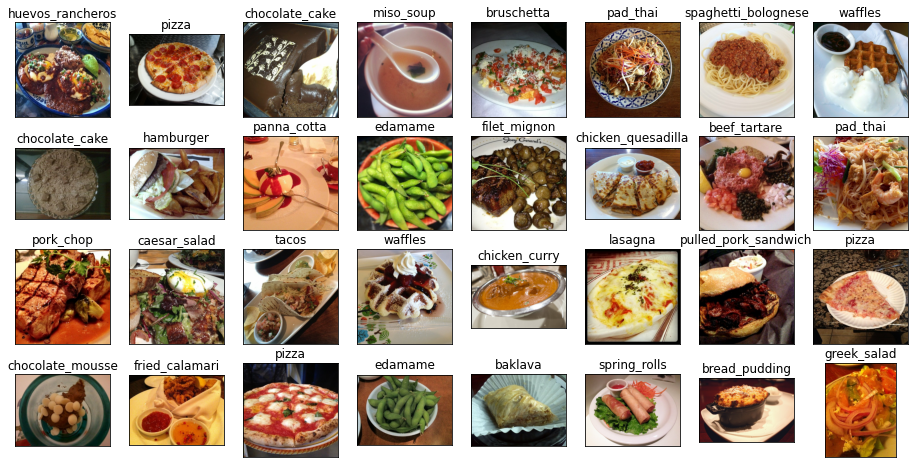

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: ds_info, test_ds, train_ds
  warnings.warn(message)


In [10]:
#!g1.1
# семплируем объекты и метки класса
some_samples = [x for x in iter(train_ds.take(32))]

# визуализация датасета
fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j][0])
    plt.title(ds_info.features['label'].int2str((some_samples[j][1].numpy())))
    plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
#!g1.1
# предобработка датасетов
train_ds = prepare(train_ds, shuffle=True, augmentation=True)
test_ds = prepare(test_ds)

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: test_ds, train_ds
  warnings.warn(message)


## Модель CNN

In [12]:
#!g1.1
# построение модели
base_model = tf.keras.applications.resnet50.ResNet50(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False, # выключаем последний слой
        weights='imagenet') # исп. веса, предобученные на Imagenet

base_model.trainable = True # Fine-tuning весов предобученной модели
   
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101),
])

94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: test_ds, train_ds
  warnings.warn(message)


In [13]:
#!g1.1
# оптимизатор
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [14]:
#!g1.1
# компиляция модели
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: test_ds, train_ds
  warnings.warn(message)


In [15]:
#!g1.1
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/fine_tune', 
    write_graph=False, update_freq=100, profile_batch=0)

In [16]:
#!g1.1
# обучение модели
history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/10


2022-09-04 17:56:10.898029: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


2131/2131 [==============================] - 189s 81ms/step - loss: 2.3797 - accuracy: 0.4207 - val_loss: 1.7789 - val_accuracy: 0.5374
Epoch 2/10
2131/2131 [==============================] - 161s 75ms/step - loss: 1.6381 - accuracy: 0.5758 - val_loss: 1.4196 - val_accuracy: 0.6245
Epoch 3/10
2131/2131 [==============================] - 160s 75ms/step - loss: 1.4048 - accuracy: 0.6303 - val_loss: 1.5070 - val_accuracy: 0.6088
Epoch 4/10
2131/2131 [==============================] - 161s 75ms/step - loss: 1.2385 - accuracy: 0.6674 - val_loss: 1.3143 - val_accuracy: 0.6501
Epoch 5/10
2131/2131 [==============================] - 161s 75ms/step - loss: 1.1248 - accuracy: 0.6949 - val_loss: 1.4098 - val_accuracy: 0.6342
Epoch 6/10
2131/2131 [==============================] - 161s 75ms/step - loss: 1.0210 - accuracy: 0.7208 - val_loss: 1.2934 - val_accuracy: 0.6619
Epoch 7/10
2131/2131 [==============================] - 162s 76ms/step - loss: 0.9384 - accuracy: 0.7392 - val_loss: 1.5371 - val

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: ds_info, tensorboard_callback, test_ds, train_ds
  warnings.warn(message)


In [17]:
#!g1.1
# оценка модели
model.evaluate(test_ds)

711/711 [==============================] - 17s 23ms/step - loss: 1.3967 - accuracy: 0.6552


[1.396688461303711, 0.6552255153656006]

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: ds_info, tensorboard_callback, test_ds, train_ds
  warnings.warn(message)


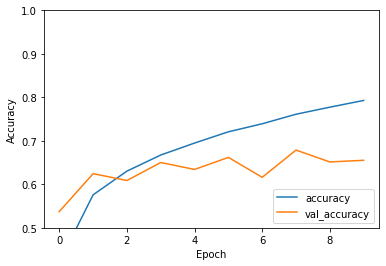

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: tensorboard_callback, test_ds, train_ds
  warnings.warn(message)


In [18]:
#!g1.1
# визуализация точности
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Предсказание модели

<ipython-input-20-6f4482217363>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(4, 8, i+1)
<ipython-input-20-6f4482217363>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(4, 8, i+1)
<ipython-input-20-6f4482217363>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will a

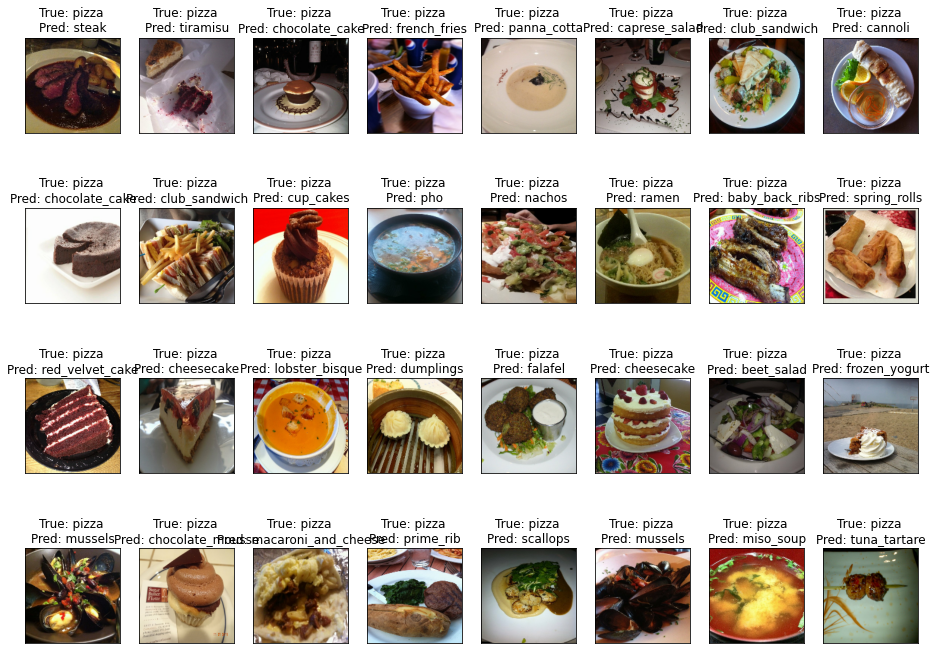

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: ds_info, tensorboard_callback, test_ds, train_ds
  warnings.warn(message)


In [20]:
#!g1.1
fig = plt.figure(figsize=(16, 12))

for j, (images, labels) in enumerate(iter(test_ds.take(2))): 
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    for i, img in enumerate(numpy_images[:32]):
      ax = fig.add_subplot(4, 8, i+1)
      ax.imshow(((img+1)*127).astype('int'))
      plt.xticks([]), plt.yticks([])

      pred = model(img[None, ...], training=False)
      pred = tf.nn.softmax(pred)
      pred = np.argmax(pred)
      plt.title(f"True: {ds_info.features['label'].int2str((some_samples[j][1]))} \nPred: {ds_info.features['label'].int2str(pred)}")
plt.show()